# Biodiversity Intactness In Phoenix Arizona

#### Emma Bea Mitchell | December 7th 2024

[Link to github repository](https://github.com/emmabeamitchell/Biodiversity_intactness)

### About: 

This notebook explores biodiversity intactness in the greater Phoenix, AZ area through mapping a biodiversity intactness index (BII). After exploring the data, we map the Phoenix Subdivision and the surrounding area to get an idea of where we are looking at. We then calculate the BII percentage change from 2017 to 2020 and map that change. 

#### Purpose:

The purpose of this notebook is to use maps tp explore the declining biodiversity in the Phoenix Subdivision.

#### Highlights:

- Navigating STAC data
- Narrowing down to information of interest in STAC data
- Using `rioxr.open_rasterio` to explore assets
- Removing bands with `.drop_vars` and `squeeze`
- Using map algebra to calculate BII differences in different years
- Using `matplotlib` to create detailed maps

#### Data:

The `io-biodiversity` data comes from the Microsoft Planetary Computer STAC catalog, which has open access to environmental data, intended for the use of building sustainable futures. We used the `planetary_computer` and `pystac_client` packages to load in this specific api data into our notebook. We then narrowed it down to `io-biodiversity` in the right years. 

The `counties` data comes from the governmental census, which creates shapefiles for political borders like counties. The data we downloaded in only for Arizona, making it easier to narrow down on the Phoenix Subdivision. All data from the government's census website is open access. 

#### References: 

Microsoft Planetary Computer. (2024). Microsoft.com. https://planetarycomputer.microsoft.com/dataset/io-biodiversity. Accessed 12-07-2024. 

‌Bureau, U. C. (2021). Cartographic Boundary Files - Shapefile. The United States Census Bureau. https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html. Accessed 12-07-2024.

### Final Output:

<img src="BII_map.png" alt="Biodiversity Intactness Index map of Phoenix">
A map of the Biodiversity Intactness Index of the Phoenix Subdivision documenting BII differences from 2017 to 2020. 

## Set up our notebook

In [1]:
# Import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import rioxarray as rioxr
import matplotlib.pyplot as plt
import planetary_computer
from geogif import gif
import os
import contextily as cx
import xarray as xr   
from pystac_client import Client  
import pystac_client
from IPython.display import Image 
from matplotlib import colormaps
import matplotlib.patches as mpatches

In [2]:
# Read in data
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

path = os.path.join('data', 'cb_2023_04_cousub_500k.shp')

counties = gpd.read_file(path)

## Explore catalog data and narrow down to point of interest

Our catalog api data has lots of metadata easily accessible. Let's go through that data and use it to find the biodiversity data we are looking for and narrow it down to just 2017 and 2020.

In [3]:
# Explore catalog metadata
print('Title:', catalog.title)
print('Description:', catalog.description)

Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer


In [4]:
# Get collections and print their names
collections = list(catalog.get_collections())  

print('Number of collections:', len(collections))

print("Collections IDs (first 10):")
for i in range(10):
    print('-', collections[i].id)

Number of collections: 124
Collections IDs (first 10):
- daymet-annual-pr
- daymet-daily-hi
- 3dep-seamless
- 3dep-lidar-dsm
- fia
- sentinel-1-rtc
- gridmet
- daymet-annual-na
- daymet-monthly-na
- daymet-annual-hi


In [5]:
# Set our bbox 
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

# Use the bbox to narrow down catalog search
search = catalog.search(collections=["io-biodiversity"], bbox=bbox_of_interest)

In [6]:
# Retrieve search items
items = search.item_collection()
len(items)

4

In [7]:
# List items in the collection
items = list(search.items())
for item in items:
    print(item)

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2019_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2018_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>


Now we know that our BII data has 4 different items, and from their names we can tell they're from 4 different years. Let's select and name the 2 items we need (2017 and 2020).

In [8]:
# Get first item in the catalog search (2020)
item_2020 = items[0]

# Get fourth item in catalog search (2017)
item_2017 = items[3]

In [9]:
# Print item IDs to confirm choices
print('ID for 2020:' , item_2020.id)

print('ID for 2017:' , item_2017.id)

ID for 2020: bii_2020_34.74464974521749_-115.38597824385106_cog
ID for 2017: bii_2017_34.74464974521749_-115.38597824385106_cog


In [10]:
# See asset keys for 2017 without long links
for key in item.assets.keys():
    print('2017', key, '--', item_2017.assets[key].title)
    
for key in item.assets.keys():
    print('2020', key, '--', item_2020.assets[key].title)

2017 data -- Biodiversity Intactness
2017 tilejson -- TileJSON with default rendering
2017 rendered_preview -- Rendered preview
2020 data -- Biodiversity Intactness
2020 tilejson -- TileJSON with default rendering
2020 rendered_preview -- Rendered preview


There's a lot we can learn by simply opening the item assets, including the bands, dimensions, and attributes. 

In [11]:
# Access item 2017's data asset
bio_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
bio_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [12]:
# Access item 2020's data asset
bio_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)
bio_2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

A plot always helps us get an overview of what we're looking at. This image is pre-rendered for us.

In [13]:
# Plot rendered preview
Image(url=item_2017.assets['rendered_preview'].href, width=500)

## Explore counties data

Our counties data is a shapefile, so we have to use more functions to extract information. First we plot to get an idea of our geometry data, then we explore crucial elements of the dataset including CRS and geometry types.

<Axes: >

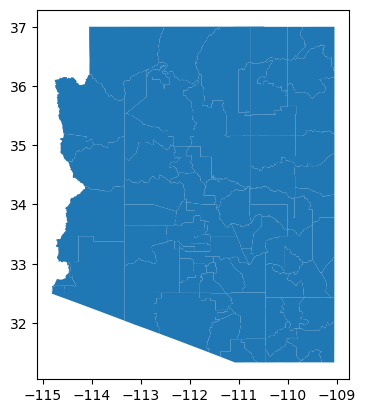

In [14]:
# Plot counties shapefile
counties.plot()

In [15]:
# Get a quick overview of counties data by displaying first 5 rows
counties.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,04,023,92295,01934961,0600000US0402392295,0402392295,Nogales,Nogales CCD,AZ,Santa Cruz County,Arizona,22,1762339489,2382710,"POLYGON ((-111.36692 31.52136, -111.33572 31.5..."
1,04,017,91632,01934949,0600000US0401791632,0401791632,Hopi,Hopi CCD,AZ,Navajo County,Arizona,22,4429144718,1975478,"POLYGON ((-110.75070 36.29843, -110.75070 36.2..."
2,04,003,90255,01934922,0600000US0400390255,0400390255,Benson,Benson CCD,AZ,Cochise County,Arizona,22,2386116644,1180899,"POLYGON ((-110.45229 31.81810, -110.45111 31.8..."
3,04,009,93111,01934978,0600000US0400993111,0400993111,San Carlos,San Carlos CCD,AZ,Graham County,Arizona,22,4363260475,30419755,"POLYGON ((-110.45719 33.29527, -110.45299 33.2..."
4,04,027,93978,01934995,0600000US0402793978,0402793978,Yuma,Yuma CCD,AZ,Yuma County,Arizona,22,637464990,12530444,"POLYGON ((-114.81418 32.56479, -114.81300 32.5..."


In [16]:
# Check the data type of the counties dataframe 
print(type(counties))

# Check the data type of the geometry column
print(type(counties.geometry))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geoseries.GeoSeries'>


In [17]:
# Look at data types of columns
counties.dtypes

STATEFP         object
COUNTYFP        object
COUSUBFP        object
COUSUBNS        object
GEOIDFQ         object
GEOID           object
NAME            object
NAMELSAD        object
STUSPS          object
NAMELSADCO      object
STATE_NAME      object
LSAD            object
ALAND            int64
AWATER           int64
geometry      geometry
dtype: object

In [18]:
# Look at geometry types 
counties.geom_type

0     Polygon
1     Polygon
2     Polygon
3     Polygon
4     Polygon
       ...   
75    Polygon
76    Polygon
77    Polygon
78    Polygon
79    Polygon
Length: 80, dtype: object

In [19]:
# Look at counties' crs
counties.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [20]:
# Find the bounds of the counties data
counties.total_bounds

array([-114.81651 ,   31.332177, -109.045223,   37.00426 ])

#### What did we learn in our exploration?

Our first exploration of our catalog data let us see the data's items, assets, pre-rendered preview image, and let us narrow down our items to only the data we need. Our first exploration of our counties data allowed us to see a preliminary plot, the CRS, the geometry types, the column data types, and an overall overview of the data. Now that we've done plenty of data exploration, we can move on!

## Let's wrangle our data so it works for our purposes

In [21]:
# Filter our arizona shapefile to just the phoenix area
phoenix_shp = counties[counties['NAME'] == 'Phoenix']

In [22]:
# View first five rows to confirm filter worked
phoenix_shp.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry
5,04,013,92601,01934968,0600000US0401392601,0401392601,Phoenix,Phoenix CCD,AZ,Maricopa County,Arizona,22,2806470560,9471133,"POLYGON ((-112.47009 33.56615, -112.47009 33.5..."


<Axes: >

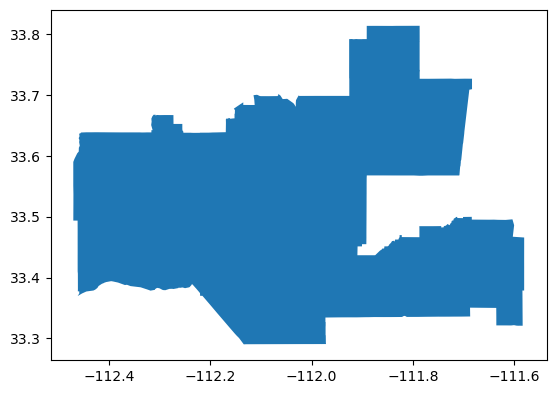

In [23]:
# Plot filtered data to confirm filter
phoenix_shp.plot()

In [24]:
# Remove length 1 dimension (band)
bio_2017 = bio_2017.squeeze()
print(bio_2017.dims, bio_2017.coords,'\n')

# Remove coordinates associated to band
bio_2017 = bio_2017.drop_vars('band')
print(bio_2017.dims, bio_2017.coords)

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('y', 'x') Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


In [25]:
# Remove length 1 dimension (band)
bio_2020 = bio_2020.squeeze()
print(bio_2020.dims, bio_2020.coords,'\n')

# Remove coordinates associated to band
bio_2020 = bio_2020.drop_vars('band')
print(bio_2020.dims, bio_2020.coords)

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('y', 'x') Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


In [26]:
# Open the raster data from our 2017 and 2020 items
phoenix_2017 = rioxr.open_rasterio(item_2017.assets['data'].href)
phoenix_2020 = rioxr.open_rasterio(item_2020.assets['data'].href)

## Plot Phoenix subdivision over a basemap of the surrounding area

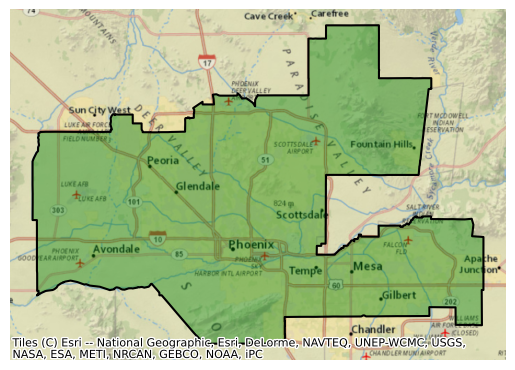

In [27]:
# Initialize figure
fig, ax = plt.subplots()

#Plot phoenix boundary
phoenix_shp.boundary.plot(ax=ax,
                edgecolor='black')

# Plot phoenix fill
phoenix_shp.plot(ax=ax, 
                color='green',
                alpha=0.4)

# Plot background data
cx.add_basemap(ax=ax, 
            crs=counties.crs, 
            source=cx.providers.Esri.NatGeoWorldMap)
ax.axis("off")
# Set title and axes labels

plt.show()

## Calculate the percentage of BII area equal to or over .75 

We are using map algebra to create a map that shows the difference in BII area equal to or over .75 from 2017 to 2020. Because we are combining the shapefile and raster data, let's first make sure that the CRSs match. Then we will begin to wrangle our data to find the area meeting our threshold.

In [28]:
# Print Phoenix shapefile CRS
phoenix_shp = phoenix_shp.to_crs('EPSG:4326')
assert phoenix_shp.crs == phoenix_2017.rio.crs

In [29]:
# Assign empty cells to nan
phoenix_2017 = phoenix_2017.rio.write_nodata(np.nan)

# Clip the phoenix 2017 data to the phoenix bounding box
phoenix_2017_clip = (phoenix_2017.rio.clip_box(*phoenix_shp.total_bounds)
                    .rio.clip(phoenix_shp.geometry)
                    )

In [30]:
# Assign empty cells to nan
phoenix_2020 = phoenix_2020.rio.write_nodata(np.nan)

# Clip the 2020 raster to the phoenix bounding box
phoenix_2020_clip = (phoenix_2020.rio.clip_box(*phoenix_shp.total_bounds)
                    .rio.clip(phoenix_shp.geometry)
                    )

Begin to use the threshold to find critical geometry values

In [31]:
# Find the number of pixels meeting the threshold
area_bii_2017 = (phoenix_2017_clip >= 0.75).sum().item()
area_bii_2020 = (phoenix_2020_clip >= 0.75).sum().item()

In [32]:
# Count the number of pixels total for each year
total_bii_2017 = phoenix_2017_clip.count().item()
total_bii_2020 = phoenix_2020_clip.count().item()

In [33]:
# Make BII area into percentages 
percentage_bii_2017 = (area_bii_2017 / total_bii_2017) * 100
percentage_bii_2020 = (area_bii_2020 / total_bii_2020) * 100

In [34]:
# Find the difference between the two rasters
phx_diff = (phoenix_2017_clip >= 0.75) ^ (phoenix_2020_clip >= 0.75)

Preliminary plot to check out what's going on

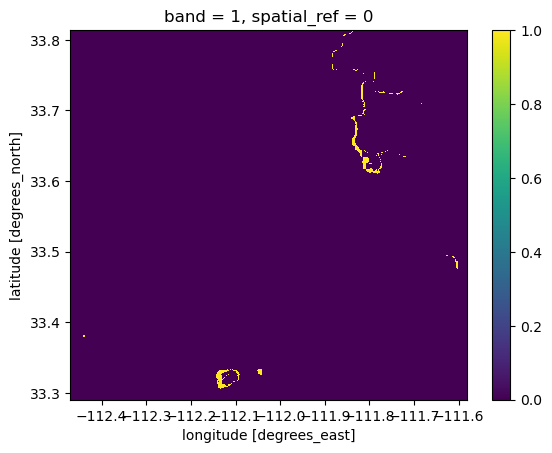

In [35]:
# Preliminary plot
phx_diff.plot()

In [36]:
# Remove data that doesn't meet threshold by turning into NAs
phx_diff = xr.where(phx_diff, 1, np.nan)

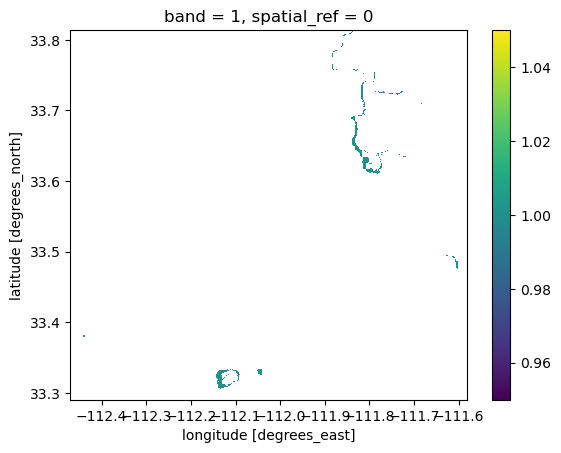

In [37]:
# Plot to confirm removal
phx_diff.plot()

## Let's make our official map!

Everything is looking great, and we're ready to combine all the pieces. Let's make our final map showing the BII area of the Phoenix Subdivision that meets our threshold (<= .75) in 2020 and then use a new color to show the biodiversity loss from 2017. 

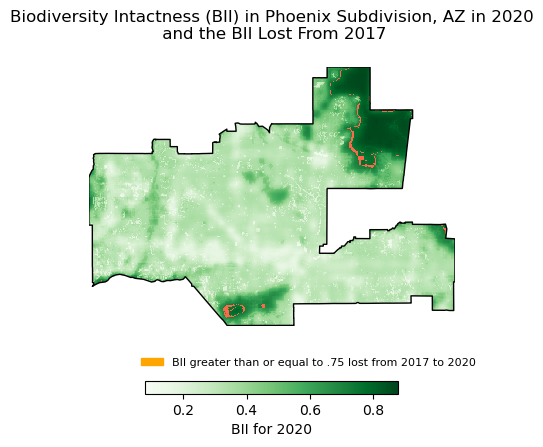

In [38]:
# initialize an empty fig and axes

fig, ax = plt.subplots()
ax.axis('off')

# Add phoenix boundary with bold edges
phoenix_shp.boundary.plot(ax=ax, color='black', edgecolor='black', linewidth=1)

# Plot the 2020 data
phoenix_2020_clip.plot(ax=ax, cmap="Greens", 
                       cbar_kwargs={'location': 'bottom', 'label': 'BII for 2020', 'shrink': 0.51})

# Add a custom legend element manually
custom_patch = mpatches.Patch(color='orange', label='BII greater than or equal to .75 lost from 2017 to 2020')

# Add custom legend
ax.legend(handles=[custom_patch], loc='lower center', fontsize=8, frameon=False, bbox_to_anchor=(0.6, -0.2))

# Plot the difference data
phx_diff.plot(ax=ax, cmap="Reds", add_colorbar=False)

# Set the title
ax.set_title("Biodiversity Intactness (BII) in Phoenix Subdivision, AZ in 2020\n and the BII Lost From 2017", 
             fontsize=12, loc='center', pad=20)
# Save plot
plt.savefig('BII_map')
# Show plot
plt.show()


### Map Description: 

Our map shows the outline of the Phoenix subdivision. We have a previous map to help place this border on a general map for context. The majority of the map is a lighter green, indexing a low values in biodiversity intactness index. Where we see the darkest green, where the index is the highest, we can see that there has been biodiversity loss in those areas since 2017. This signifies a potential pattern emerging of biodiversity loss in Phoenix's remaining intact areas. This is an alarming pattern, as only a few spots of high index areas remain. If we were to see an even more updated map, we can assume that the high biodiversity index areas will have shrunk even more. 